# ML Project

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
import random
import metoder
import pandas as pd




Importing dataset:

In [2]:
#path:
#file_path = r"C:\Users\vikto\Documents\Skole\Datadrevne_systemer\ML_Project\glass_data-4_lev.csv"
file_path = "../Datasett/mushrooms.csv"
#importing file and print how the structure of data were inported. 
df = pd.read_csv(file_path)

# Define a mapping dictionary
#type_mapping = {'T1': 0, 'T2': 1, 'T3': 2, 'T4': 3, 'T5': 4, 'T6': 5}

# Apply the mapping to the 'Type' column
#df['Type'] = df['Type'].map(type_mapping)

#drop ID number
#df = df.drop(columns=['Id'])

# Verify the 'Type' column is now of type int64
print(df['class'].dtype)
df.info()

object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above

### Small exploration of data:

In [3]:
unique_rows = df.drop_duplicates()


num_unique_rows = unique_rows.shape[0]

print("Number of unique rows: ", num_unique_rows)


Number of unique rows:  8124


In [10]:
# Check the number of unique rows in the DataFrame
num_unique_rows = df.drop_duplicates().shape[0]

# Print the result
print("Number of unique rows:", num_unique_rows)

Number of unique rows: 8124


The data set clearly shows that T1, T2 is most frequently. 

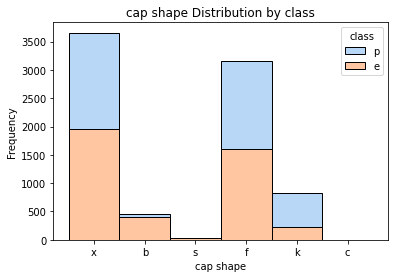

In [4]:
# Create a histogram of age with hue for income
sns.histplot(data=df, x='cap-shape', hue='class', multiple='stack', palette='pastel')

# Add labels and title
plt.xlabel('cap shape')
plt.ylabel('Frequency')
plt.title('cap shape Distribution by class')

# Show the plot
plt.show()

In [5]:
#for col in df.columns[:-1]:  # Exclude the 'Type' column
 #   sns.boxplot(x='Type', y=col, data=df)
  #  plt.show()

One-hot encoding to ensure the best result

In [6]:
import pandas as pd

# Perform one-hot encoding for all categorical columns except the "class" column
df_encoded = pd.get_dummies(df, columns=["cap-shape","cap-surface","cap-color","bruises","odor","gill-attachment","gill-spacing","gill-size","gill-color","stalk-shape","stalk-root","stalk-surface-above-ring","stalk-surface-below-ring","stalk-color-above-ring","stalk-color-below-ring","veil-type","veil-color","ring-number","ring-type","spore-print-color","population","habitat"])

# You can also encode the target variable "class" if needed
# class_encoded = pd.get_dummies(df["class"], prefix="class")

# Replace "p" with 1 and "e" with 0 in the "class" column in the df_encoded DataFrame
df_encoded['class'] = df_encoded['class'].apply(lambda x: 1 if x == 'p' else 0)

# Convert the "class" column to a numeric data type (int)
#df_encoded['class'] = pd.to_numeric(df['class'])

# Print the resulting DataFrame
print(df_encoded)


      class  cap-shape_b  cap-shape_c  cap-shape_f  cap-shape_k  cap-shape_s  \
0         1            0            0            0            0            0   
1         0            0            0            0            0            0   
2         0            1            0            0            0            0   
3         1            0            0            0            0            0   
4         0            0            0            0            0            0   
...     ...          ...          ...          ...          ...          ...   
8119      0            0            0            0            1            0   
8120      0            0            0            0            0            0   
8121      0            0            0            1            0            0   
8122      1            0            0            0            1            0   
8123      0            0            0            0            0            0   

      cap-shape_x  cap-surface_f  cap-s

### Make a neural network:

Split data to training and validation and Scale the data: 

In [7]:
# Prepare the Data for training:
X = df_encoded.drop(columns=['class']).values  # Features (excluding 'Type' column)
y = df_encoded['class'].values  # Labels

# Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
print(type(X_train[0][0]))

<class 'numpy.float64'>


Create pytorch model:

In [8]:

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=7, shuffle=True)
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=7)

# Build the Neural Network
class GlassClassifier(nn.Module):
    def __init__(self):
        super(GlassClassifier, self).__init__()
        self.fc1 = nn.Linear(9, 64)
        self.fc2 = nn.Linear(64, 90)
        self.fc3 = nn.Linear(90, 64)
        self.fc4 = nn.Linear(64, 6)  # 6 output units for 6 types
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = GlassClassifier()

# Step 5: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 6: Train the Model
# Define a list to store training losses
train_losses = []

# Define the number of epochs
num_epochs = 200

# Train the model and track the training loss
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Calculate average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

# Plot the training loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (7x117 and 9x64)

Evaluate model:

In [ ]:
# Step 7: Evaluate the Model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'T{i}' for i in range(1, 8)],
            yticklabels=[f'T{i}' for i in range(1, 8)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

correct = sum(pred == label for pred, label in zip(all_preds, all_labels))
accuracy = correct / len(all_labels)
#print()
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

In [ ]:
rf = metoder.randomforest(df_encoded)

In [ ]:
gb = metoder.gradientboost(df_encoded)

In [ ]:
lr = metoder.linearregression(df_encoded)

In [ ]:
dr = metoder.decisionregressor(df_encoded)

In [ ]:
mlp = metoder.mlpregression(df_encoded)

In [ ]:
svr = metoder.supportvectoregressor(df_encoded)

In [ ]:
KNN = metoder.kneighborsregressor(df_encoded)

In [ ]:
models = ['KNN Regressor', 'Linear Regression', 'Decision Tree Regressor' ,'Random Forest Regressor',
 'Gradient Boosting Regressor','Support Vector Regressor', 'MLP Regressor']
tests_score = [KNN, lr, dr, rf, gb, svr, mlp]
compare_models = pd.DataFrame({ "Algorithms": models, "Tests Score": tests_score })
compare_models.sort_values(by = "Tests Score", ascending = False)

In [ ]:
%matplotlib inline
plt.figure(figsize=(8,8))
sns.barplot(x = "Tests Score", y = "Algorithms", data = compare_models)
plt.show()